# Imports 

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os, sys
parent_dir = os.path.abspath('..')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
from bench_utils import *
from plot_utils import *

# For bigfiles
from io import TextIOWrapper
from zipfile import ZipFile

import numpy as np

def stdef(vals):  
    avg = sum(vals) / len(vals);  
    sumderiv = 0;  
    for val in vals:
        sumderiv = sumderiv + val * val
    sumderivavg = sumderiv / (len(vals) - 1)
    return math.sqrt(sumderivavg - (avg*avg))

In [2]:
plot_dir='./plots'
os.makedirs(plot_dir, exist_ok=True)

# Plot rules

In [3]:
# Color rules (based on https://personal.sron.nl/~pault/)
append_col = "#117733"
write_col  = "#44AA99"
write_none_col       = "#88CCEE"
write_mq_deadline_col = "#999933"
reset_col = "#DDCC77"
read_col   = "#CC6677"
read_none_col = "#88CCEE"
read_mq_deadline_col = "#AA4499"
undefined_col = "#DDDDDD"
state_machine_col = "#CC3311"

lbaf0_pattern = r'\\'
lbaf2_pattern = '.'

text_font_size = 21
marker_font_size = 21
label_font_size = 21
axes_font_size = 21

plt.rc('text', usetex=True)
plt.rc('pdf', use14corefonts=True, fonttype=42)
plt.rc('ps', useafm=True)
plt.rc('font', size=text_font_size, weight="bold", family='serif', serif='cm10')
plt.rc('axes', labelsize=axes_font_size,labelweight="bold")    
plt.rc('xtick', labelsize=label_font_size)    
plt.rc('ytick', labelsize=label_font_size)    
plt.rc('legend', fontsize=label_font_size)  
plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
plt.rcParams['text.latex.preamble'] = r'\boldmath'

/tmp/ipykernel_104146/7442158.py:29: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]


# Append and write performance

## I/O latencies of Append and Write, 512 byte requests for 512 pagesize, 4KiB requests for 4KiB pagesize

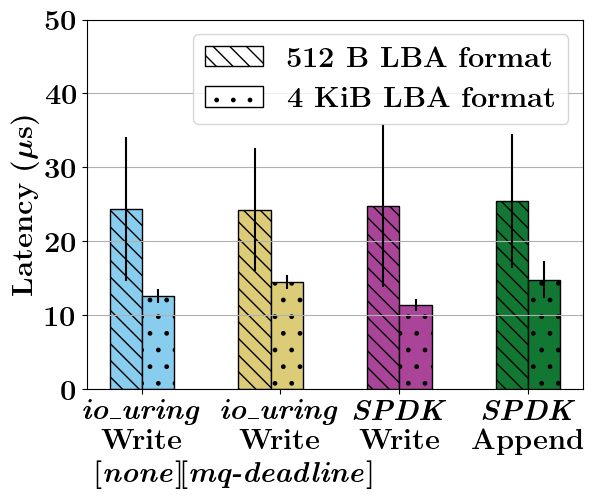

In [4]:
fig, ax = plt.subplots()

kiops_512 = []
kiopse_512 = []
bs_512 = 512
for path in [
           BenchPath(
            string_to_io_engine("io_uring"), "zns-a", 
            "lbaf0", "write", 1, 1, bs_512
            ),
            BenchPath(
            string_to_io_engine("io_uring"), "zns-a", 
            "lbaf0", "writemq", 1, 1, bs_512
            ),
            BenchPath(
            string_to_io_engine("spdk"), "zns-a", 
            "lbaf0", "write", 1, 1, bs_512
            ),
            BenchPath(
            string_to_io_engine("spdk"), "zns-a", 
            "lbaf0", "append", 1, 1, bs_512
            )
]:
    dat = parse_fio_file(path, FioOperation.WRITE)
    kiops_512.append(dat.lat_mean / 1000)
    kiopse_512.append(dat.lat_stddev / 1000)
k512 = ax.bar([x-0.125 for x in range(4)], kiops_512, yerr=kiopse_512, align='center', 
              color=[write_none_col, reset_col, read_mq_deadline_col, append_col], 
              width=0.25, label="512 byte pagesize format", 
              hatch=lbaf0_pattern, edgecolor = "black", ecolor="black")

kiops_4k = []
kiopse_4k = []
bs_4096 = 4096
for path in [
           BenchPath(
            string_to_io_engine("io_uring"), "zns-a", 
            "lbaf2", "write", 1, 1, bs_4096
            ),
            BenchPath(
            string_to_io_engine("io_uring"), "zns-a", 
            "lbaf2", "writemq", 1, 1, bs_4096
            ),
            BenchPath(
            string_to_io_engine("spdk"), "zns-a", 
            "lbaf2", "write", 1, 1, bs_4096
            ),
            BenchPath(
            string_to_io_engine("spdk"), "zns-a", 
            "lbaf2", "append", 1, 1, bs_4096
            )
]:
    dat = parse_fio_file(path, FioOperation.WRITE)
    kiops_4k.append(dat.lat_mean / 1000)
    kiopse_4k.append(dat.lat_stddev / 1000)
k4 = ax.bar([x+0.125 for x in range(4)], kiops_4k, yerr=kiopse_4k, align='center', 
            color=[write_none_col, reset_col, read_mq_deadline_col, append_col], 
            width=0.25, label="4KiB pagesize format", 
            hatch=lbaf2_pattern, edgecolor = "black", ecolor="black")


plt.ylabel(r'\textbf{Latency ($\mu$s)}')
ax.yaxis.grid() # horizontal lines
plt.ylim(0, 50)

plot_512_patch = mpatches.Patch(facecolor='white', label=r'\textbf{512 B LBA format}'
                                ,hatch=lbaf0_pattern, edgecolor = "black")
plot_4KiB_patch = mpatches.Patch(facecolor='white', label=r'\textbf{4 KiB LBA format}',
                                 hatch='.', edgecolor = "black")

plt.legend(handles = [plot_512_patch, plot_4KiB_patch])

ax.set_xticks([x*1.07 if x == 1 else x for x in range(4)], labels=[
    r'\textbf{\textit{io_uring}}' + '\n' + r'\textbf{Write}' + '\n' + r'\textbf{[\textit{none}]}',
    r'\textbf{\textit{io_uring}}' + '\n' + r'\textbf{Write}' + '\n' + r'\textbf{[\textit{mq-deadline}]}',
    r'\textbf{\textit{SPDK}}' + '\n' + r'\textbf{Write}',
    r'\textbf{\textit{SPDK}}' + '\n' + r'\textbf{Append}',
]
)
fig.savefig(f"{plot_dir}/f1-lbaf_512_versus_lbaf_4KiB(QD=1).pdf", bbox_inches="tight")

## I/O latencies of Append and Write, 4KiB requests for writes, 8KiB requests for appends

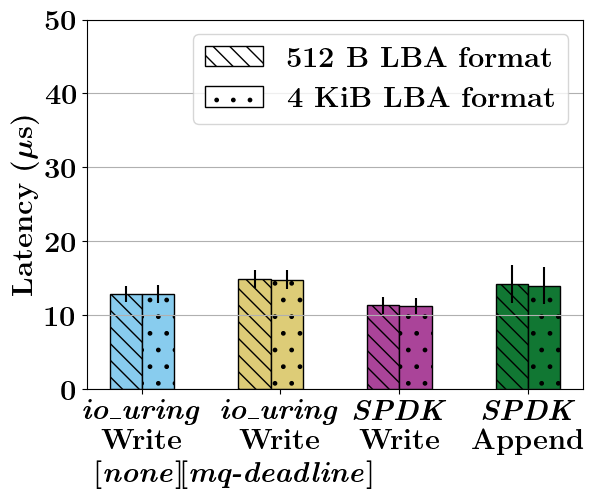

In [5]:
fig, ax = plt.subplots()

kiops_512 = []
kiopse_512 = []
bs_512=8192
for path in [
           BenchPath(
            string_to_io_engine("io_uring"), "zns-a", 
            "lbaf0", "write", 1, 1, bs_512
            ),
            BenchPath(
            string_to_io_engine("io_uring"), "zns-a", 
            "lbaf0", "writemq", 1, 1, bs_512
            ),
            BenchPath(
            string_to_io_engine("spdk"), "zns-a", 
            "lbaf0", "write", 1, 1, bs_512
            ),
            BenchPath(
            string_to_io_engine("spdk"), "zns-a", 
            "lbaf0", "append", 1, 1, bs_512
            )
]:
    dat = parse_fio_file(path, FioOperation.WRITE)
    kiops_512.append(dat.lat_mean / 1000)
    kiopse_512.append(dat.lat_stddev / 1000)
k512 = ax.bar([x-0.125 for x in range(4)], kiops_512, yerr=kiopse_512, align='center', 
              color=[write_none_col, reset_col, read_mq_deadline_col, append_col], 
              width=0.25, label="512 byte pagesize format", 
              hatch=lbaf0_pattern, edgecolor = "black", ecolor="black")

kiops_4k = []
kiopse_4k = []
bs_4k=8192
for path in [
           BenchPath(
            string_to_io_engine("io_uring"), "zns-a", 
            "lbaf2", "write", 1, 1, bs_4k
            ),
            BenchPath(
            string_to_io_engine("io_uring"), "zns-a", 
            "lbaf2", "writemq", 1, 1, bs_4k
            ),
            BenchPath(
            string_to_io_engine("spdk"), "zns-a", 
            "lbaf2", "write", 1, 1, bs_4k
            ),
            BenchPath(
            string_to_io_engine("spdk"), "zns-a", 
            "lbaf2", "append", 1, 1, bs_4k
            )
]:
    dat = parse_fio_file(path, FioOperation.WRITE)
    kiops_4k.append(dat.lat_mean / 1000)
    kiopse_4k.append(dat.lat_stddev / 1000)
k4 = ax.bar([x+0.125 for x in range(4)], kiops_4k, yerr=kiopse_4k, align='center', 
            color=[write_none_col, reset_col, read_mq_deadline_col, append_col], 
            width=0.25, label="4KiB pagesize format", 
            hatch=lbaf2_pattern, edgecolor = "black", ecolor="black")


plt.ylabel(r'\textbf{Latency ($\mu$s)}')
ax.yaxis.grid() # horizontal lines
plt.ylim(0, 50)

plot_512_patch = mpatches.Patch(facecolor='white', label=r'\textbf{512 B LBA format}', 
                                hatch=lbaf0_pattern, edgecolor = "black")
plot_4KiB_patch = mpatches.Patch(facecolor='white', label=r'\textbf{4 KiB LBA format}', 
                                 hatch='.', edgecolor = "black")

plt.legend(handles = [plot_512_patch, plot_4KiB_patch])

ax.set_xticks([x*1.07 if x == 1 else x for x in range(4)], labels=[
    r'\textbf{\textit{io_uring}}' + '\n' + r'\textbf{Write}' + '\n' + r'\textbf{[\textit{none}]}',
    r'\textbf{\textit{io_uring}}' + '\n' + r'\textbf{Write}' + '\n' + r'\textbf{[\textit{mq-deadline}]}',
    r'\textbf{\textit{SPDK}}' + '\n' + r'\textbf{Write}',
    r'\textbf{\textit{SPDK}}' + '\n' + r'\textbf{Append}',
]
)
fig.savefig(f"{plot_dir}/f2-lbaf_512_versus_lbaf_4KiB_8KiB_requests(QD=1).pdf", bbox_inches="tight")

## SPDK I/O throughput for writes in IOPS (QD=1) 

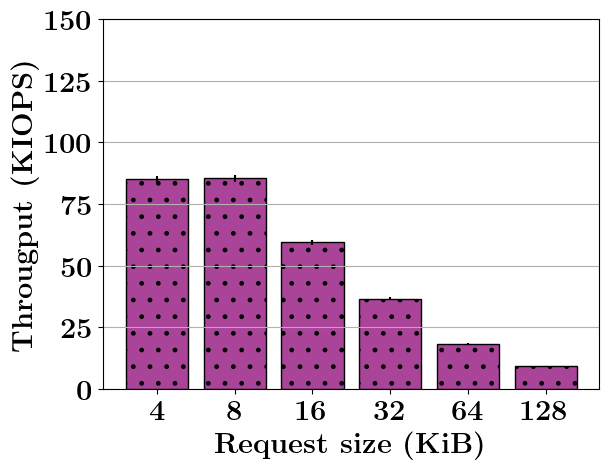

In [6]:
qd = 1
bss = [4096, 8192, 16384, 32768, 65536, 131072]

kiops = []
kiopse = []
for bs in bss:
    dat = parse_fio_file(
        BenchPath(
            string_to_io_engine("spdk"), "zns-a", 
            "lbaf2", "write", 1, qd, bs
            ), FioOperation.WRITE
        )
    kiops.append(dat.iops_mean / 1000)
    kiopse.append(dat.iops_stddev / 1000)

    
fig, ax = plt.subplots()
plt.ylabel(r"\textbf{Througput (KIOPS)}")
plt.xlabel(r"\textbf{Request size (KiB)}")
ax.yaxis.grid() # horizontal lines
plt.ylim(0, 150)

ax.bar(range(len(bss)), kiops, yerr=kiopse, align='center', color=read_mq_deadline_col, 
       hatch=lbaf2_pattern, edgecolor = "black", ecolor="black")
ax.set_xticks(range(len(bss)), labels=[r"\textbf{4}", r"\textbf{8}", r"\textbf{16}", r"\textbf{32}"
                                       , r"\textbf{64}", r"\textbf{128}"])
fig.savefig(f"{plot_dir}/f4-lbaf4KiB_optimal_spdk_write_size.pdf", bbox_inches="tight")

## SPDK I/O throughput for appends in IOPS (QD=1) 

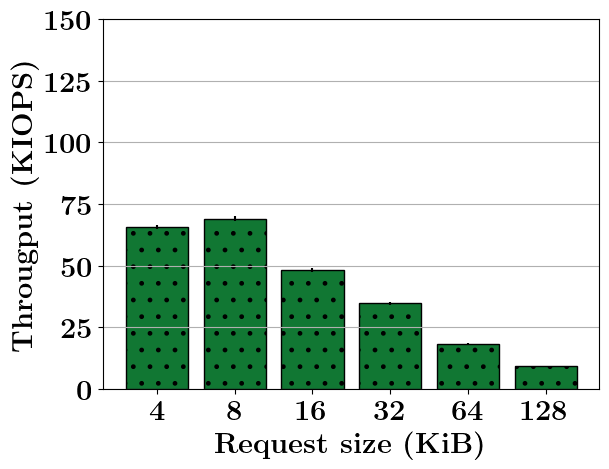

In [7]:
qd = 1
bss = [4096, 8192, 16384, 32768, 65536, 131072]

kiops = []
kiopse = []
for bs in bss:
    dat = parse_fio_file(
        BenchPath(
            string_to_io_engine("spdk"), "zns-a", 
            "lbaf2", "append", 1, qd, bs
            ), FioOperation.WRITE
        )
    kiops.append(dat.iops_mean / 1000)
    kiopse.append(dat.iops_stddev / 1000)

    
fig, ax = plt.subplots()
plt.ylabel(r"\textbf{Througput (KIOPS)}")
plt.xlabel(r"\textbf{Request size (KiB)}")
ax.yaxis.grid() # horizontal lines
plt.ylim(0, 150)

ax.bar(range(len(bss)), kiops, yerr=kiopse, align='center', color=append_col, 
       hatch=lbaf2_pattern, edgecolor = "black", ecolor="black")
ax.set_xticks(range(len(bss)), labels=[r"\textbf{4}", r"\textbf{8}", r"\textbf{16}", r"\textbf{32}"
                                       , r"\textbf{64}", r"\textbf{128}"])
fig.savefig(f"{plot_dir}/f3-lbaf4KiB_optimal_append_size.pdf", bbox_inches="tight")

#  Scalability: Intra-zone versus inter-zone performance

##  Intra-zone scalability in IOPS for 4 KiB requests (variable QD, 1 zone/thread)

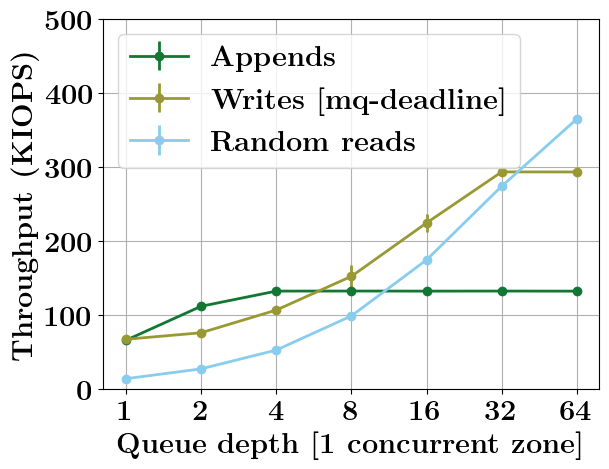

In [8]:
fig, ax = plt.subplots()
plt.xlabel(r'\textbf{Queue depth [1 concurrent zone]}')
plt.ylabel(r'\textbf{Throughput (KIOPS)}')
ax.grid(True)

qdss = [1,2,4,8,16, 32, 64]
rang = range(len(qdss))    
    
kiops = []
kiopse = []
for qd in qdss:
    dat = parse_fio_file(
        BenchPath(
            string_to_io_engine("spdk"), "zns-a", 
            "lbaf2", "append", 1, qd, 4096
            ), FioOperation.WRITE
        )
    kiops.append(dat.iops_mean / 1000)
    kiopse.append(dat.iops_stddev / 1000)

plt.errorbar(
    rang,
    kiops,
    yerr=kiopse,
    linewidth=2,
    label=r'\textbf{Appends}',
    color=append_col,
    fmt='-o',
)

kiops = []
kiopse = []
for qd in qdss:
    dat = parse_fio_file(
        BenchPath(
            string_to_io_engine("io_uring"), "zns-a", 
            "lbaf2", "writemq", 1, qd, 4096
            ), FioOperation.WRITE
        )
    kiops.append(dat.iops_mean / 1000)
    kiopse.append(dat.iops_stddev / 1000)

plt.errorbar(
    rang,
    kiops,
    yerr=kiopse,
    linewidth=2,
    label=r'\textbf{Writes [mq-deadline]}',
    color=write_mq_deadline_col,
    fmt='-o',
)

kiops = []
kiopse = []
for qd in qdss:
    dat = parse_fio_file(
        BenchPath(
            string_to_io_engine("spdk"), "zns-a", 
            "lbaf2", "randread", 1, qd, 4096
            ), FioOperation.READ
        )
    kiops.append(dat.iops_mean / 1000)
    kiopse.append(dat.iops_stddev / 1000)
    
plt.errorbar(
    rang,
    kiops,
    yerr=kiopse,
    linewidth=2,
    label=r'\textbf{Random reads}',
    color=read_none_col,
    fmt='-o',
)
                
plt.ylim(0, 500)
ax.set_xticks(rang, labels=[r'\textbf{' + str(qd) + '}' for qd in qdss])

plt.legend()
fig.savefig(f"{plot_dir}/f7-lbaf4KiB_1zone_scalability_no_mq.pdf", bbox_inches="tight")

## inter-zone scalability in IOPS for 4 KiB requests (QD 1, variable zones/threads)

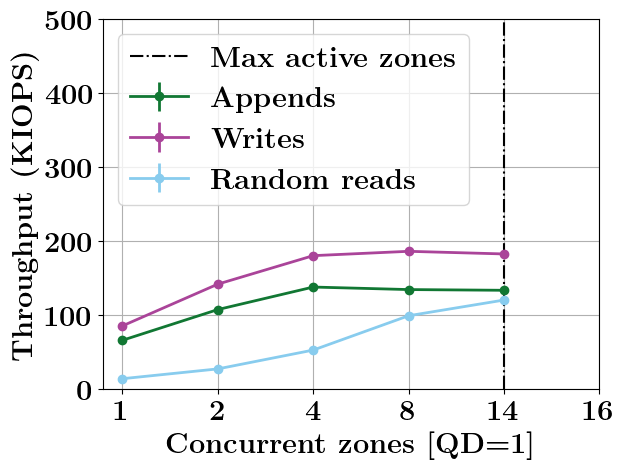

In [9]:
fig, ax = plt.subplots()
plt.xlabel(r"\textbf{Concurrent zones [QD=1]}")
plt.ylabel(r"\textbf{Throughput (KIOPS)}")
ax.grid(True)

qdss = [1,2,4,8,14]
rang = range(len(qdss))    
    
kiops = []
kiopse = []
for qd in qdss:
    dat = parse_fio_file(
        BenchPath(
            string_to_io_engine("spdk"), "zns-a", 
            "lbaf2", "append", qd, 1, 4096
            ), FioOperation.WRITE
        )
    kiops.append(dat.iops_mean / 1000)
    kiopse.append(dat.iops_stddev / 1000)   
plt.errorbar(
    rang,
    kiops,
    yerr=kiopse,
    linewidth=2,
    label=r"\textbf{Appends}",
    color=append_col,
    fmt='-o',
)

kiops = []
kiopse = []
for qd in qdss:
    dat = parse_fio_file(
        BenchPath(
            string_to_io_engine("spdk"), "zns-a", 
            "lbaf2", "write", qd, 1, 4096
            ), FioOperation.WRITE
        )
    kiops.append(dat.iops_mean / 1000)
    kiopse.append(dat.iops_stddev / 1000)
plt.errorbar(
    rang,
    kiops,
    yerr=kiopse,
    linewidth=2,
    label=r"\textbf{Writes}",
    color=read_mq_deadline_col,
    fmt='-o',
)


kiops = []
kiopse = []
for qd in qdss:
    dat = parse_fio_file(
        BenchPath(
            string_to_io_engine("spdk"), "zns-a", 
            "lbaf2", "randread", qd, 1, 4096
            ), FioOperation.READ
        )
    kiops.append(dat.iops_mean / 1000)
    kiopse.append(dat.iops_stddev / 1000)
plt.errorbar(
    rang,
    kiops,
    yerr=kiopse,
    linewidth=2,
    label=r"\textbf{Random reads}",
    color=read_none_col,
    fmt='-o',
)
                
plt.ylim(0, 500)
ax.set_xticks(range(len(qdss)+1), labels=[r'\textbf{' + str(qd) + '}' for qd in qdss + [16]])
ax.set_xlim(-0.2,5)
plt.vlines(4,0, 500, colors="black", linestyles="dashdot", label=r"\textbf{Max active zones}")

plt.legend(loc='upper left')
fig.savefig(f"{plot_dir}/f6-lbaf4KiB_concurrent_zone_scalability.pdf", bbox_inches="tight")

## Inter-zone and intra-zone bandwidths using SPDK; concurrency level is queue depth for appends, and concurrent zones for writes

In [10]:
# Temporarily reduce font size for this plot.
plt.rc('font', size=18, weight="bold")         
plt.rc('axes', labelsize=21,labelweight="bold")    
plt.rc('xtick', labelsize=21)    
plt.rc('ytick', labelsize=21)    
plt.rc('legend', fontsize=15)  

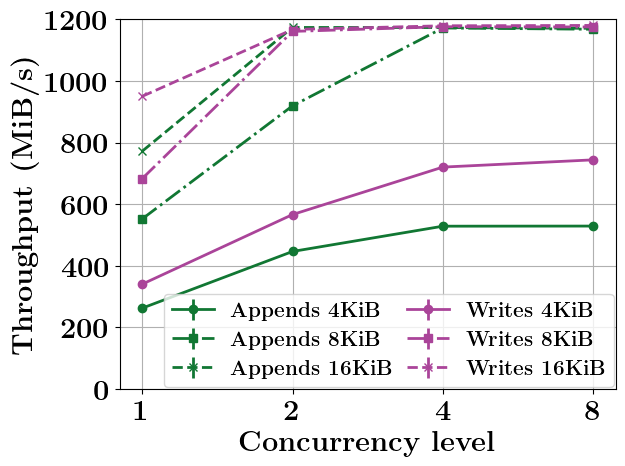

In [11]:
fig, ax = plt.subplots()
plt.xlabel(r"\textbf{Concurrency level}")
plt.ylabel(r"\textbf{Throughput (MiB/s)}")
ax.grid(True)

qdss = [1,2,4,8]
rang = range(len(qdss))    
    
kiops = []
kiopse = []
for qd in qdss:
    dat = parse_fio_file(
        BenchPath(
            string_to_io_engine("spdk"), "zns-a", 
            "lbaf2", "append", 1, qd, 4096
            ), FioOperation.WRITE
        )
    kiops.append(dat.iops_mean / 1000)
    kiopse.append(dat.iops_stddev / 1000)

plt.errorbar(
    rang,
    [(k * 4096) / 1024 for k in kiops],
    yerr=kiopse,
    linewidth=2,
    label=r"\textbf{Appends 4KiB}",
    color=append_col,
    fmt='-o',
)

kiops = []
kiopse = []
for qd in qdss:
    dat = parse_fio_file(
        BenchPath(
            string_to_io_engine("spdk"), "zns-a", 
            "lbaf2", "append", 1, qd, 8192
            ), FioOperation.WRITE
        )
    kiops.append(dat.iops_mean / 1000)
    kiopse.append(dat.iops_stddev / 1000)

plt.errorbar(
    rang,
    [(k * 8192) / 1024 for k in kiops],
    yerr=kiopse,
    linewidth=2,
    label=r"\textbf{Appends 8KiB}",
    color=append_col,
    fmt='-.s',
)


kiops = []
kiopse = []
for qd in qdss:
    dat = parse_fio_file(
        BenchPath(
            string_to_io_engine("spdk"), "zns-a", 
            "lbaf2", "append", 1, qd, 16384
            ), FioOperation.WRITE
        )
    kiops.append(dat.iops_mean / 1000)
    kiopse.append(dat.iops_stddev / 1000)

plt.errorbar(
    rang,
    [(k * 16384) / 1024 for k in kiops],
    yerr=kiopse,
    linewidth=2,
    label=r"\textbf{Appends 16KiB}",
    color=append_col,
    fmt='--x',
)

kiops = []
kiopse = []
for qd in qdss:
    dat = parse_fio_file(
        BenchPath(
            string_to_io_engine("spdk"), "zns-a", 
            "lbaf2", "write", qd, 1, 4096
            ), FioOperation.WRITE
        )
    kiops.append(dat.iops_mean / 1000)
    kiopse.append(dat.iops_stddev / 1000)

plt.errorbar(
    rang,
    [(k * 4096) / 1024 for k in kiops],
    yerr=kiopse,
    linewidth=2,
    label=r"\textbf{Writes 4KiB}",
    color=read_mq_deadline_col,
    fmt='-o',
)


kiops = []
kiopse = []
for qd in qdss:
    dat = parse_fio_file(
        BenchPath(
            string_to_io_engine("spdk"), "zns-a", 
            "lbaf2", "write", qd, 1, 8192
            ), FioOperation.WRITE
        )
    kiops.append(dat.iops_mean / 1000)
    kiopse.append(dat.iops_stddev / 1000)

plt.errorbar(
    rang,
    [(k * 8192) / 1024 for k in kiops],
    yerr=kiopse,
    linewidth=2,
    label=r"\textbf{Writes 8KiB}",
    color=read_mq_deadline_col,
    fmt='-.s',
)



kiops = []
kiopse = []
for qd in qdss:
    dat = parse_fio_file(
        BenchPath(
            string_to_io_engine("spdk"), "zns-a", 
            "lbaf2", "write", qd, 1, 16384
            ), FioOperation.WRITE
        )
    kiops.append(dat.iops_mean / 1000)
    kiopse.append(dat.iops_stddev / 1000)

plt.errorbar(
    rang,
    [(k * 16384) / 1024 for k in kiops],
    yerr=kiopse,
    linewidth=2,
    label=r"\textbf{Writes 16KiB}",
    color=read_mq_deadline_col,
    fmt='--x',
)
                
plt.ylim(0, 1200)
ax.set_xticks(rang, labels=[r'\textbf{' + str(qd) + '}' for qd in qdss])

plt.legend(loc="lower right", ncol=2, columnspacing=0.7, borderaxespad=0.1)
fig.savefig(f"{plot_dir}/f7-lbaf4KiB_scalability.pdf", bbox_inches="tight")

In [12]:
# Recover font size
plt.rc('font', size=text_font_size, weight="bold", family='serif', serif='cm10')
plt.rc('axes', labelsize=axes_font_size,labelweight="bold")    
plt.rc('xtick', labelsize=label_font_size)    
plt.rc('ytick', labelsize=label_font_size)    
plt.rc('legend', fontsize=label_font_size) 

#  Zone State Machine Transition Costs

In [13]:
# Get all data in one go (takes a few secs)
reset_100 = []; reset_50 = []; reset_25 = []; reset_12 = []; reset_6 = []; reset_1 = []; reset_0 = []
reset_fin_100 = []; reset_fin_50 = []; reset_fin_25 = []; reset_fin_12 = []; reset_fin_6 = []
reset_fin_1 = []; reset_fin_0 = []
fin_100 = []; fin_50 = []; fin_25 = []; fin_12 = []; fin_6 = []; fin_1 = []; fin_0 = []

reset_fin_files = ["../data/custom/zns-a/partial_reset/run1",
                   "../data/custom/zns-a/partial_reset/run2",
                   "../data/custom/zns-a/partial_reset/run3",
                   "../data/custom/zns-a/partial_reset/run4"
                  ]

for filename in reset_fin_files:
    with open(filename, "r") as f:
        lines = f.readlines()
        reset_100 = reset_100 + [int(line.split(',')[1]) for line in lines if 'reset_275712,' in line]
        reset_50 = reset_50 + [int(line.split(',')[1]) for line in lines if 'reset_137856,' in line]
        reset_25 = reset_25 + [int(line.split(',')[1]) for line in lines if 'reset_68928,' in line]
        reset_12 = reset_12 + [int(line.split(',')[1]) for line in lines if 'reset_34464,' in line]
        reset_6 = reset_6 + [int(line.split(',')[1]) for line in lines if 'reset_17232,' in line]
        reset_1 = reset_1 + [int(line.split(',')[1]) for line in lines if 'reset_1,' in line]  
        reset_0 = reset_0 + [int(line.split(',')[1]) for line in lines if 'reset_0' in line]
        fin_100 = fin_100 + [int(line.split(',')[1]) for line in lines if 'finish_275711,' in line]
        fin_50 = fin_50 + [int(line.split(',')[1]) for line in lines if 'finish_137856,' in line]
        fin_25 = fin_25 + [int(line.split(',')[1]) for line in lines if 'finish_68928,' in line]
        fin_12 = fin_12 + [int(line.split(',')[1]) for line in lines if 'finish_34464,' in line]
        fin_6 = fin_6 + [int(line.split(',')[1]) for line in lines if 'finish_17232,' in line]
        fin_1 = fin_1 + [int(line.split(',')[1]) for line in lines if 'finish_1,' in line]
        fin_0 = fin_0 + [int(line.split(',')[1]) for line in lines if 'finish_0' in line]   
        reset_fin_100 = reset_fin_100 + [int(line.split(',')[1]) for line in lines
                                         if 'reset_finished_275711,' in line]
        reset_fin_50 = reset_fin_50 + [int(line.split(',')[1]) for line in lines 
                                       if 'reset_finished_137856,' in line]
        reset_fin_25 = reset_fin_25 + [int(line.split(',')[1]) for line in lines 
                                       if 'reset_finished_68928,' in line]
        reset_fin_12 = reset_fin_12 + [int(line.split(',')[1]) for line in lines 
                                       if 'reset_finished_34464,' in line]
        reset_fin_6 = reset_fin_6 + [int(line.split(',')[1]) for line in lines
                                     if 'reset_finished_17232,' in line]
        reset_fin_1 = reset_fin_1 + [int(line.split(',')[1]) for line in lines 
                                     if 'reset_finished_1,' in line]
        reset_fin_0 = reset_fin_0 + [int(line.split(',')[1]) for line in lines 
                                     if 'reset_finished_0' in line]    
   
reset_fin_files = [("run1", "../data/custom/zns-a/partial_finish/run1.zip"),
                   ("run2", "../data/custom/zns-a/partial_finish/run2.zip")]

for innername, filename in reset_fin_files:
    with ZipFile(filename) as zf:
        with zf.open(innername, 'r') as f:
            lines = [l.decode("utf-8") for l in f.readlines()]
            reset_100 = reset_100 + [int(line.split(',')[1]) for line in lines if 'reset_275712,' in line]
            reset_50 = reset_50 + [int(line.split(',')[1]) for line in lines if 'reset_137856,' in line]
            reset_25 = reset_25 + [int(line.split(',')[1]) for line in lines if 'reset_68928,' in line]
            reset_12 = reset_12 + [int(line.split(',')[1]) for line in lines if 'reset_34464,' in line]
            reset_6 = reset_6 + [int(line.split(',')[1]) for line in lines if 'reset_17232,' in line]
            reset_1 = reset_1 + [int(line.split(',')[1]) for line in lines if 'reset_1,' in line]  
            reset_0 = reset_0 + [int(line.split(',')[1]) for line in lines if 'reset_0' in line]
            fin_100 = fin_100 + [int(line.split(',')[1]) for line in lines if 'finish_275711,' in line]
            fin_50 = fin_50 + [int(line.split(',')[1]) for line in lines if 'finish_137856,' in line]
            fin_25 = fin_25 + [int(line.split(',')[1]) for line in lines if 'finish_68928,' in line]
            fin_12 = fin_12 + [int(line.split(',')[1]) for line in lines if 'finish_34464,' in line]
            fin_6 = fin_6 + [int(line.split(',')[1]) for line in lines if 'finish_17232,' in line]
            fin_1 = fin_1 + [int(line.split(',')[1]) for line in lines if 'finish_1,' in line]
            fin_0 = fin_0 + [int(line.split(',')[1]) for line in lines if 'finish_0' in line]   
            reset_fin_100 = reset_fin_100 + [int(line.split(',')[1]) for line in lines
                                             if 'reset_finished_275711,' in line]
            reset_fin_50 = reset_fin_50 + [int(line.split(',')[1]) for line in lines 
                                           if 'reset_finished_137856,' in line]
            reset_fin_25 = reset_fin_25 + [int(line.split(',')[1]) for line in lines 
                                           if 'reset_finished_68928,' in line]
            reset_fin_12 = reset_fin_12 + [int(line.split(',')[1]) for line in lines 
                                           if 'reset_finished_34464,' in line]
            reset_fin_6 = reset_fin_6 + [int(line.split(',')[1]) for line in lines
                                         if 'reset_finished_17232,' in line]
            reset_fin_1 = reset_fin_1 + [int(line.split(',')[1]) for line in lines 
                                         if 'reset_finished_1,' in line]
            reset_fin_0 = reset_fin_0 + [int(line.split(',')[1]) for line in lines 
                                         if 'reset_finished_0' in line]
            
write_implicit_lat = []
write_explicit_lat = []
write_open_lat = []

append_implicit_lat = []
append_explicit_lat = []
append_open_lat = []

with ZipFile("../data/custom/zns-a/explicit_versus_implicit_io/run1.zip") as zf:
        with zf.open("run1", 'r') as f:
            lines = [l.decode("utf-8") for l in f.readlines()]
            write_implicit_lat = [int(line.split(',')[1]) for line in lines if 'write_implicit,' in line]
            write_explicit_lat = [int(line.split(',')[1]) for line in lines if 'write_explicit,' in line]
            write_open_lat = [int(line.split(',')[1]) for line in lines if 'write_implicit_opened,' in line]
            append_implicit_lat = [int(line.split(',')[1]) for line in lines if 'append_implicit,' in line]
            append_explicit_lat = [int(line.split(',')[1]) for line in lines if 'append_explicit,' in line]
            append_open_lat = [int(line.split(',')[1]) for line in lines if 'append_implicit_opened,' in line]

            
with open("../data/custom/zns-a/explicit_versus_implicit_io/run2_append_implicitly_opened", "r") as f:
    lines =  f.readlines()
    append_open_lat = append_open_lat + [int(line.split(',')[1]) for line in lines if 'append_implicit_opened,' in line]
        
with open("../data/custom/zns-a/explicit_versus_implicit_io/run2_write_implicitly_opened", "r") as f:
    lines =  f.readlines()
    write_open_lat = write_open_lat + [int(line.split(',')[1]) for line in lines if 'write_implicit_opened,' in line]
        
with open("../data/custom/zns-a/explicit_versus_implicit_io/run2_write_implicit", "r") as f:
    lines =  f.readlines()
    write_implicit_lat = write_implicit_lat + [int(line.split(',')[1]) for line in lines if 'write_implicit,' in line]
        
with open("../data/custom/zns-a/explicit_versus_implicit_io/run2_append_implicit", "r") as f:
    lines =  f.readlines()
    append_implicit_lat = append_implicit_lat + [int(line.split(',')[1]) for line in lines if 'append_implicit,' in line]
        
with open("../data/custom/zns-a/explicit_versus_implicit_io/run2_write_explicit", "r") as f:
    lines =  f.readlines()
    write_explicit_lat = write_explicit_lat +  [int(line.split(',')[1]) for line in lines if 'write_explicit,' in line]
        
with open("../data/custom/zns-a/explicit_versus_implicit_io/run2_append_explicit", "r") as f:
    lines =  f.readlines()
    append_explicit_lat = append_explicit_lat + [int(line.split(',')[1]) for line in lines if 'append_explicit,' in line]
    
close_impl_lat = []
close_expl_lat = []

close_impl_write_lat = []
close_expl_write_lat = []
 
close_lat = []    
   
for filename in ["../data/custom/zns-a/open_close/run1", "../data/custom/zns-a/open_close/run2"]:  
    with open(filename, "r") as f:
        lines =  f.readlines()
        close_impl_lat = close_impl_lat + [int(line.split(',')[1]) for line in lines if 'close_implicit,' in line]
        close_expl_lat = close_expl_lat + [int(line.split(',')[1]) for line in lines if 'close,' in line]
        close_impl_write_lat = close_impl_write_lat + [int(line.split(',')[1]) for line in lines if 'close_implicit_write,' in line]
        close_expl_write_lat = close_expl_write_lat + [int(line.split(',')[1]) for line in lines if 'close_write,' in line]
        close_lat = close_impl_lat + close_expl_lat
        
        
explicit_open = []
with open("../data/custom/zns-a/pure_read/fil", "r") as f:
    lines =  f.readlines()
    explicit_open = [int(line.split(',')[1]) for line in lines if 'empty_' in line]

with open("../data/custom/zns-a/inteference/write_reset_inteference_fill_opens", "r") as f:
    lines =  f.readlines()
    explicit_open = explicit_open + [int(line.split(',')[1]) for line in lines if 'open' in line]  
    
with open("../data/custom/zns-a/inteference/append_reset_inteference_fill_opens", "r") as f:
    lines =  f.readlines()
    explicit_open = explicit_open + [int(line.split(',')[1]) for line in lines if 'open' in line]      
    
with open("../data/custom/zns-a/inteference/read_reset_inteference_fill_open", "r") as f:
    lines =  f.readlines()
    explicit_open = explicit_open + [int(line.split(',')[1]) for line in lines if 'open' in line] 

## The cost of opening and closing zones

In [14]:
print("Write latencies 4KiB:")
print("\tto implicitly opened zone:", len(write_implicit_lat), "(cnt), ",
      sum(write_implicit_lat)/ len(write_implicit_lat), "(mean ns)")
print("\tto explicitly opened zone:", len(write_explicit_lat), "(cnt), ",
      sum(write_explicit_lat)/ len(write_explicit_lat), "(mean ns)")

print("Append latencies 4KiB:")
print("\tto implicitly opened zone:", len(append_implicit_lat), "(cnt), ",
      sum(append_implicit_lat)/ len(append_implicit_lat), "(mean ns)")
print("\tto explicitly opened zone:", len(append_explicit_lat), "(cnt), ",
      sum(append_explicit_lat)/ len(append_explicit_lat), "(mean ns)")

print("Open latencies:")
print("\texplicitly:", len(explicit_open), "(cnt), ",
      sum(explicit_open) / len(explicit_open), "(mean ns)")
print("\timplicitly with a write:", len(write_open_lat), "(cnt), ",
      sum(write_open_lat)/ len(write_open_lat), "(mean ns)")
print("\timplicitly with an append:", len(append_open_lat), "(cnt), ",
      sum(append_open_lat)/ len(append_open_lat), "(mean ns)")

print("Close latencies:")
print("\timplicitly opened zone:", len(close_impl_lat), "(cnt), ",
      sum(close_impl_lat)/ len(close_impl_lat), "(mean ns)")
print("\texplicitly opened zone:", len(close_expl_lat), "(cnt), ",
      sum(close_expl_lat)/ len(close_expl_lat), "(mean ns)")
print("\tClose implict zone with last write:", len(close_impl_write_lat), "(cnt), ", 
      sum(close_impl_write_lat)/ len(close_impl_write_lat), "(mean ns)")
print("\tClose explicit zone with last write:", len(close_expl_write_lat), "(cnt), ",
      sum(close_expl_write_lat)/ len(close_expl_write_lat), "(mean ns)")
print("\tAll:", len(close_lat), "(cnt), ",
      sum(close_lat)/ len(close_lat), "(mean ns)")

Write latencies 4KiB:
	to implicitly opened zone: 2857110 (cnt),  11622.546484384571 (mean ns)
	to explicitly opened zone: 2857120 (cnt),  11621.906842554741 (mean ns)
Append latencies 4KiB:
	to implicitly opened zone: 2857110 (cnt),  14660.668751640644 (mean ns)
	to explicitly opened zone: 2857120 (cnt),  14659.775255502043 (mean ns)
Open latencies:
	explicitly: 2356 (cnt),  9559.443548387097 (mean ns)
	implicitly with a write: 462 (cnt),  13641.926406926406 (mean ns)
	implicitly with an append: 462 (cnt),  17491.948051948053 (mean ns)
Close latencies:
	implicitly opened zone: 1826 (cnt),  11072.687294633079 (mean ns)
	explicitly opened zone: 1826 (cnt),  10963.296276013143 (mean ns)
	Close implict zone with last write: 1826 (cnt),  15243.851040525738 (mean ns)
	Close explicit zone with last write: 1826 (cnt),  15190.297918948521 (mean ns)
	All: 3652 (cnt),  11017.99178532311 (mean ns)


##  reset latency of partially-occupied zones

Average reset lat at 0 occ (ms): 1.0774044304171282
Average reset lat at 50 occ (ms): 11.608276717977114
Average reset lat at 50 occ when finished (ms): 8.522756562938353
Average reset lat at 100 occ (ms): 16.1866571627907


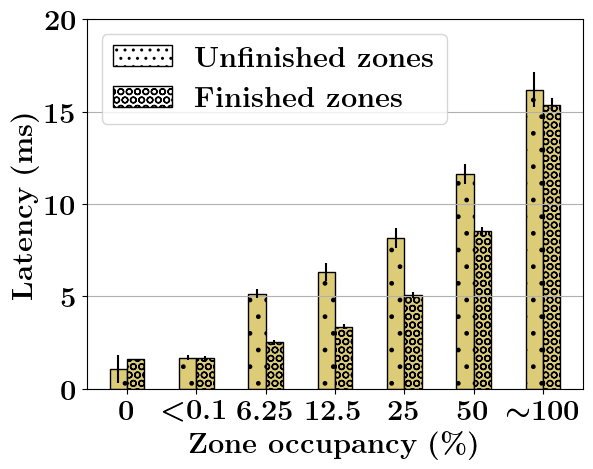

In [15]:
labels = [ r'\textbf{' + t + '}' for t in ["0", "$<$0.1", "6.25", "12.5", "25", "50", "$\sim$100"]]

lats = [
    sum(reset_0) / len(reset_0) / 1000_000,
    sum(reset_1) / len(reset_1) / 1000_000,
    sum(reset_6) / len(reset_6) / 1000_000,
    sum(reset_12) / len(reset_12) / 1000_000,
    sum(reset_25) / len(reset_25) / 1000_000,
    sum(reset_50) / len(reset_50) / 1000_000,
    sum(reset_100) / len(reset_100) / 1000_000,
]

yerr= [
    stdef(reset_0) / 1000_000,
    stdef(reset_1) / 1000_000,
    stdef(reset_6) / 1000_000,
    stdef(reset_12) / 1000_000,
    stdef(reset_25) / 1000_000,
    stdef(reset_50) / 1000_000,
    stdef(reset_100) / 1000_000,
]

fig, ax = plt.subplots()
plt.ylabel(r"\textbf{Latency (ms)}")
plt.xlabel(r"\textbf{Zone occupancy (\%)}")
ax.yaxis.grid() # horizontal lines
plt.ylim(0, 20)

ax.bar([x - 0.125 for x in range(len(labels))], lats, yerr=yerr, align='center', color=reset_col, 
       hatch=lbaf2_pattern, edgecolor = "black", ecolor="black", width = 0.25)

lats = [
    sum(reset_fin_0) / len(reset_fin_0) / 1000_000,
    sum(reset_fin_1) / len(reset_fin_1) / 1000_000,
    sum(reset_fin_6) / len(reset_fin_6) / 1000_000,
    sum(reset_fin_12) / len(reset_fin_12) / 1000_000,
    sum(reset_fin_25) / len(reset_fin_25) / 1000_000,
    sum(reset_fin_50) / len(reset_fin_50) / 1000_000,
    sum(reset_fin_100) / len(reset_fin_100) / 1000_000,
]

yerr= [
    stdef(reset_fin_0) / 1000_000,
    stdef(reset_fin_1) / 1000_000,
    stdef(reset_fin_6) / 1000_000,
    stdef(reset_fin_12) / 1000_000,
    stdef(reset_fin_25) / 1000_000,
    stdef(reset_fin_50) / 1000_000,
    stdef(reset_fin_100) / 1000_000,
]

plot_512_patch = mpatches.Patch(facecolor='white', label=r'\textbf{Unfinished zones}', 
                                hatch='..', edgecolor = "black")
plot_4KiB_patch = mpatches.Patch(facecolor='white', label=r'\textbf{Finished zones}', 
                                 hatch='OO', edgecolor = "black")

plt.legend(handles = [plot_512_patch, plot_4KiB_patch], loc = 'upper left')


ax.bar([x + 0.125 for x in range(len(labels))], lats, yerr=yerr, align='center', color=reset_col, 
       hatch="OO", edgecolor = "black", ecolor="black", width=0.25)
ax.set_xticks(range(len(labels)), labels=labels)

plt.savefig(f"{plot_dir}/f8b-partial_zone_reset_latency.pdf", bbox_inches="tight") 

print("Average reset lat at 0 occ (ms):", sum(reset_0) / len(reset_0) / 1000_000)
print("Average reset lat at 50 occ (ms):", sum(reset_50) / len(reset_50) / 1000_000)
print("Average reset lat at 50 occ when finished (ms):", sum(reset_fin_50) / len(reset_fin_50) / 1000_000)
print("Average reset lat at 100 occ (ms):", sum(reset_100) / len(reset_100) / 1000_000)

In [16]:
print("Combined finish and reset lat (total cost of first finishing and then resetting):")
print("0 occ (ms):", (sum(fin_0) / len(fin_0) / 1000_000 + 
      sum(reset_fin_0) / len(reset_fin_0) / 1000_000) / 
      (sum(reset_0) / len(reset_0) / 1000_000))
print("1 page (ms):", (sum(fin_1) / len(fin_1) / 1000_000 + 
      sum(reset_fin_1) / len(reset_fin_1) / 1000_000) / 
      (sum(reset_1) / len(reset_1) / 1000_000))
print("6.25 occ (ms):", (sum(fin_6) / len(fin_6) / 1000_000 + 
      sum(reset_fin_6) / len(reset_fin_6) / 1000_000) / 
      (sum(reset_6) / len(reset_6) / 1000_000))
print("12.5 occ (ms):", (sum(fin_12) / len(fin_12) / 1000_000 + 
      sum(reset_fin_12) / len(reset_fin_12) / 1000_000) / 
      (sum(reset_12) / len(reset_12) / 1000_000))
print("25 occ (ms):", (sum(fin_25) / len(fin_25) / 1000_000 + 
      sum(reset_fin_25) / len(reset_fin_25) / 1000_000) / 
      (sum(reset_25) / len(reset_25) / 1000_000))
print("50 occ (ms):", (sum(fin_50) / len(fin_50) / 1000_000 + 
      sum(reset_fin_50) / len(reset_fin_50) / 1000_000) / 
      (sum(reset_50) / len(reset_50) / 1000_000))

Combined finish and reset lat (total cost of first finishing and then resetting):
0 occ (ms): 1.4888999412346353
1 page (ms): 539.1350152400848
6.25 occ (ms): 165.0682184020997
12.5 occ (ms): 126.04281661836956
25 occ (ms): 84.25319367053211
50 occ (ms): 40.08193656969211


## finish latency of partially-occupied zones

Average finish lat at 0 occ (ms): 13.545857881136952
Average reset lat at 1 page (ms): 907.5073302436323
Average reset lat at 100 occ - 1 page (ms): 3.0715570295311925


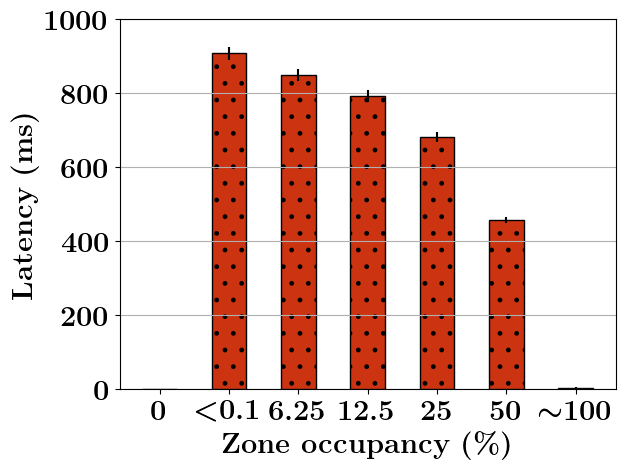

In [17]:
labels = [ r'\textbf{' + t + '}' for t in  ["0", "$<$0.1", "6.25", "12.5", "25", "50", "$\sim$100"]]
       
lats = [
    sum(fin_0) / len(fin_0) / 1000_000,
    sum(fin_1) / len(fin_1) / 1000_000,
    sum(fin_6) / len(fin_6) / 1000_000,
    sum(fin_12) / len(fin_12) / 1000_000,
    sum(fin_25) / len(fin_25) / 1000_000,
    sum(fin_50) / len(fin_50) / 1000_000,
    sum(fin_100) / len(fin_100) / 1000_000,
]

yerr= [
    stdef(fin_0) / 1000_000,
    stdef(fin_1) / 1000_000,
    stdef(fin_6) / 1000_000,
    stdef(fin_12) / 1000_000,
    stdef(fin_25) / 1000_000,
    stdef(fin_50) / 1000_000,
    stdef(fin_100) / 1000_000,
]

fig, ax = plt.subplots()
plt.ylabel(r"\textbf{Latency (ms)}")
plt.xlabel(r"\textbf{Zone occupancy (\%)}")
ax.yaxis.grid() # horizontal lines
plt.ylim(0, 1000)

ax.bar(range(len(labels)), lats, yerr=yerr, align='center', color=state_machine_col, 
       hatch=lbaf2_pattern, edgecolor = "black", ecolor="black", width = 0.5)
ax.set_xticks(range(len(labels)), labels=labels)
    
plt.savefig(f"{plot_dir}/f10-partial_zone_finish_latency.pdf", bbox_inches="tight")    

print("Average finish lat at 0 occ (ms):", sum(fin_0) / len(fin_0) / 1000)
print("Average reset lat at 1 page (ms):", sum(fin_1) / len(fin_1) / 1000_000)
print("Average reset lat at 100 occ - 1 page (ms):", sum(fin_100) / len(fin_100) / 1000_000)

# I/O inteference on random reads

In [18]:
# Get all data
bandwidth_write1_zns = []
bandwidth_write2_zns = []
bandwidth_write3_zns = []
bandwidth_write4_zns = []
with open("../data/custom/zns-a/long2/log_zns_32_1115_bw.1.log", "r") as f:
    bandwidth_write1_zns = [int(line.split(',')[1]) for line in  f.readlines() if len(line.split(',')) > 1]
with open("../data/custom/zns-a/long2/log_zns_32_1115_bw.2.log", "r") as f:
    bandwidth_write2_zns = [int(line.split(',')[1]) for line in  f.readlines() if len(line.split(',')) > 1]
with open("../data/custom/zns-a/long2/log_zns_32_1115_bw.3.log", "r") as f:
    bandwidth_write3_zns = [int(line.split(',')[1]) for line in  f.readlines() if len(line.split(',')) > 1]
with open("../data/custom/zns-a/long2/log_zns_32_1115_bw.4.log", "r") as f:
    bandwidth_write4_zns = [int(line.split(',')[1]) for line in  f.readlines() if len(line.split(',')) > 1]
bandwidth_write_zns = [x[0] + x[1] + x[2] + x[3] for x in zip(bandwidth_write1_zns, 
                                                          bandwidth_write2_zns, bandwidth_write3_zns,
                                                          bandwidth_write4_zns)]


bandwidth_write1_2 = []
bandwidth_write2_2 = []
bandwidth_write3_2 = []
bandwidth_write4_2 = []
with open("../data/custom/zns-a/long3/log_32_1115_bw.1.log", "r") as f:
    bandwidth_write1_2 = [int(line.split(',')[1]) for line in  f.readlines() if len(line.split(',')) > 1]
with open("../data/custom/zns-a/long3/log_32_1115_bw.2.log", "r") as f:
    bandwidth_write2_2 = [int(line.split(',')[1]) for line in  f.readlines() if len(line.split(',')) > 1]
with open("../data/custom/zns-a/long3/log_32_1115_bw.3.log", "r") as f:
    bandwidth_write3_2 = [int(line.split(',')[1]) for line in  f.readlines() if len(line.split(',')) > 1]
with open("../data/custom/zns-a/long3/log_32_1115_bw.4.log", "r") as f:
    bandwidth_write4_2 = [int(line.split(',')[1]) for line in  f.readlines() if len(line.split(',')) > 1]
bandwidth_write_2 = [x[0] + x[1] + x[2] + x[3] for x in zip(bandwidth_write1_2, 
                                                          bandwidth_write2_2, bandwidth_write3_2,
                                                          bandwidth_write4_2)]


bandwidth_write1_2 = []
bandwidth_write2_2 = []
bandwidth_write3_2 = []
bandwidth_write4_2 = []
with open("../data/custom/zns-a/long/finally_b.1.log", "r") as f:
    bandwidth_write1_2 = [int(line.split(',')[1]) for line in  f.readlines() if len(line.split(',')) > 1]
with open("../data/custom/zns-a/long/finally_b.2.log", "r") as f:
    bandwidth_write2_2 = [int(line.split(',')[1]) for line in  f.readlines() if len(line.split(',')) > 1]
with open("../data/custom/zns-a/long/finally_b.3.log", "r") as f:
    bandwidth_write3_2 = [int(line.split(',')[1]) for line in  f.readlines() if len(line.split(',')) > 1]
with open("../data/custom/zns-a/long/finally_b.4.log", "r") as f:
    bandwidth_write4_2 = [int(line.split(',')[1]) for line in  f.readlines() if len(line.split(',')) > 1]
bandwidth_write_3 = [x[0] + x[1] + x[2] + x[3] for x in zip(bandwidth_write1_2, 
                                                          bandwidth_write2_2, bandwidth_write3_2,
                                                          bandwidth_write4_2)]

bandwidth_read = []
with open("../data/custom/zns-a/long2/log_zns_32_1115_bw.5.log", "r") as f:
    bandwidth_read = [int(line.split(',')[1]) for line in  f.readlines() if len(line.split(',')) > 1]
    
bandwidth_read2 = []
with open("../data/custom/zns-a/long2/log_zns_32_750_bw.5.log", "r") as f:
    bandwidth_read2 = [int(line.split(',')[1]) for line in  f.readlines() if len(line.split(',')) > 1]
    
bandwidth_read3 = []
with open("../data/custom/zns-a/long2/log_zns_32_250_bw.5.log", "r") as f:
    bandwidth_read3 = [int(line.split(',')[1]) for line in  f.readlines() if len(line.split(',')) > 1]
    
bandwidth_read4 = []
with open("../data/custom/zns-a/long2/log_zns_32_0_bw.1.log", "r") as f:
    bandwidth_read4 = [int(line.split(',')[1]) for line in  f.readlines() if len(line.split(',')) > 1]
    
bandwidth_read_nvme = []
with open("../data/custom/zns-a/long3/log_32_1115_bw.5.log", "r") as f:
    bandwidth_read_nvme = [int(line.split(',')[1]) for line in  f.readlines() if len(line.split(',')) > 1]
    
bandwidth_read_nvme2 = []
with open("../data/custom/zns-a/long3/log_32_750_bw.5.log", "r") as f:
    bandwidth_read_nvme2 = [int(line.split(',')[1]) for line in  f.readlines() if len(line.split(',')) > 1]
    
bandwidth_read_nvme3 = []
with open("../data/custom/zns-a/long3/log_32_250_bw.5.log", "r") as f:
    bandwidth_read_nvme3 = [int(line.split(',')[1]) for line in  f.readlines() if len(line.split(',')) > 1]
    
bandwidth_read_nvme4 = []
with open("../data/custom/zns-a/long3/log_32_0_bw.1.log", "r") as f:
    bandwidth_read_nvme4 = [int(line.split(',')[1]) for line in  f.readlines() if len(line.split(',')) > 1]  

## write throughput of concurrent workloads issuing random writes

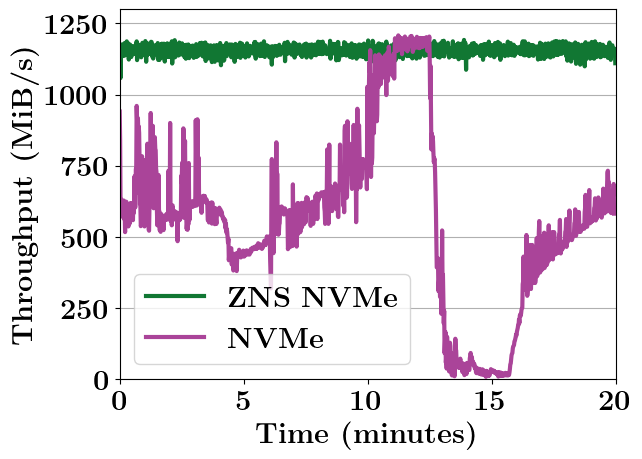

In [19]:
fig, ax = plt.subplots()

plt.ylabel(r"\textbf{Throughput (MiB/s)}")
plt.xlabel(r"\textbf{Time (minutes)}")
ax.yaxis.grid() # horizontal lines
plt.ylim(0, 1300)
plt.xlim(0, 60*20)

x = range(len(bandwidth_write_zns))
y = bandwidth_write_zns

plt.errorbar(
    x,
    [yi / 1024 for yi in y],
    linewidth=3,
    label=r"\textbf{ZNS NVMe}",
    color=append_col,
    fmt='-',
)


x = range(len(bandwidth_write_2))
y = bandwidth_write_2

plt.errorbar(
    x,
    [yi / 1024 for yi in y],
    linewidth=3,
    label=r"\textbf{NVMe}",
    color=read_mq_deadline_col,
    fmt='-',
)


plt.xticks([x * 60 * 5 for x in range(5)],[r'\textbf{' + str(x * 5) + '}' for x in range(5)])
plt.legend(loc='lower left')

plt.savefig(f"{plot_dir}/f12-gc_zns_versus_nvme.pdf", bbox_inches="tight")

## random reads throughput while concurrent workloads are issuing random writes

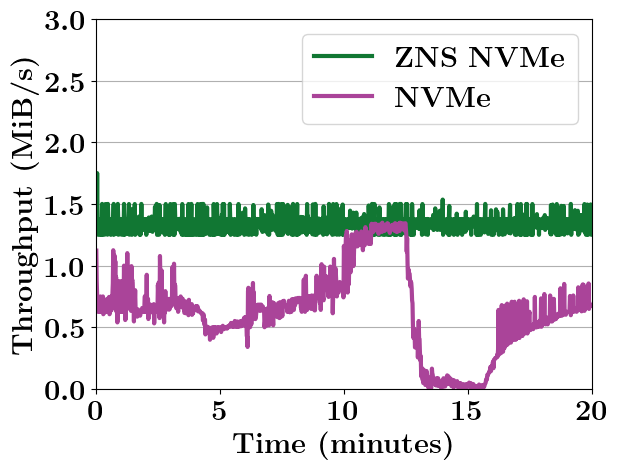

In [20]:
fig, ax = plt.subplots()

plt.ylabel(r"\textbf{Throughput (MiB/s)}")
plt.xlabel(r"\textbf{Time (minutes)}")
ax.yaxis.grid() # horizontal lines
plt.ylim(0, 3)
plt.xlim(0, 600*2)

x = range(len(bandwidth_read))
y = bandwidth_read

plt.errorbar(
    x,
    [yi / 1024 for yi in y],
    linewidth=3,
    label=r"\textbf{ZNS NVMe}",
    color=append_col,
    fmt='-',
)

x = range(len(bandwidth_read_nvme))
y = bandwidth_read_nvme

plt.errorbar(
    x,
    [yi / 1024 for yi in y],
    linewidth=3,
    label=r"\textbf{NVMe}",
    color=read_mq_deadline_col,
    fmt='-',
)

plt.xticks([x * 60 * 5 for x in range(5)],[r'\textbf{' + str(x * 5) + '}' for x in range(5)])
plt.legend(loc='upper right')

plt.savefig(f"{plot_dir}/f12-read_inteference_zns_versus_nvme.pdf", bbox_inches="tight")

# Reset interference

In [21]:
# Get all data
normal_reads = []
read_int_open = []
read_int_reads = []
read_int_resets = []

with open("../data/custom/zns-a/pure_read/read", "r") as f:
    lines =  f.readlines()
    normal_reads = [int(line.split(',')[1]) for line in lines if 'read' in line]
    normal_reads = [read for read in normal_reads if read > 0]
with open("../data/custom/zns-a/inteference/read_reset_inteference_resets", "r") as f:
    lines =  f.readlines()
    read_int_resets = [int(line.split(',')[1]) for line in lines if 'reset' in line]
with open("../data/custom/zns-a/inteference/read_reset_inteference_reads", "r") as f:
    lines =  f.readlines()
    read_int_reads = [int(line.split(',')[1]) for line in lines if 'read' in line]
    read_int_reads = [read for read in read_int_reads if read > 0]
with open("../data/custom/zns-a/inteference/read_reset_inteference_fill_open", "r") as f:
    lines =  f.readlines()
    read_int_open = [int(line.split(',')[1]) for line in lines if 'open' in line]    
    read_int_open = [read for read in read_int_open if read > 0]  
    
write_int_open = []
write_int_fill_writes = []
write_int_writes = []
write_int_resets = []

with open("../data/custom/zns-a/inteference/write_reset_inteference_resets", "r") as f:
    lines =  f.readlines()
    write_int_resets = [int(line.split(',')[1]) for line in lines if 'reset' in line]
    write_int_resets = [read for read in write_int_resets if read > 0]
with open("../data/custom/zns-a/inteference/write_reset_inteference_writes", "r") as f:
    lines =  f.readlines()
    write_int_writes = [int(line.split(',')[1]) for line in lines if 'write' in line]
    write_int_writes = [read for read in write_int_writes if read > 0]
with open("../data/custom/zns-a/inteference/write_reset_inteference_fill_writes", "r") as f:
    lines =  f.readlines()
    write_int_fill_writes = [int(line.split(',')[1]) for line in lines if 'write' in line]
    write_int_fill_writes = [read  for read in write_int_fill_writes if read > 0]
with open("../data/custom/zns-a/inteference/write_reset_inteference_fill_opens", "r") as f:
    lines =  f.readlines()
    write_int_open = [int(line.split(',')[1]) for line in lines if 'open' in line]    
    
append_int_open = []
append_int_fill_appends = []
append_int_appends = []
append_int_resets = []

with open("../data/custom/zns-a/inteference/append_reset_inteference_resets", "r") as f:
    lines =  f.readlines()
    append_int_resets = [int(line.split(',')[1]) for line in lines if 'reset' in line]
    append_int_resets = [read for read in append_int_resets if read > 0]
with open("../data/custom/zns-a/inteference/append_reset_inteference_appends", "r") as f:
    lines =  f.readlines()
    append_int_appends = [int(line.split(',')[1]) for line in lines if 'append' in line]
    append_int_appends = [read for read in append_int_appends if read > 0]
with open("../data/custom/zns-a/inteference/append_reset_inteference_fill_appends", "r") as f:
    lines =  f.readlines()
    append_int_fill_appends = [int(line.split(',')[1]) for line in lines if 'append' in line]
    append_int_fill_appends = [read for read in append_int_fill_appends if read > 0]  

Read/reset interference test P95-lat:
- normal read lat: 81816.0
- read during reset lat: 81812.0
- reset during read lat: 28000321.15
Write/reset interference test P95-lat:
- normal write lat: 12419.0
- write during reset lat: 12508.0
- reset during write lat: 32000852.8
Append/reset interference test P95-lat::
- normal append lat: 15661.0
- append during reset lat: 15620.0
- reset during append lat: 31476163.95
Pure reset P95 lat: 17935489.6


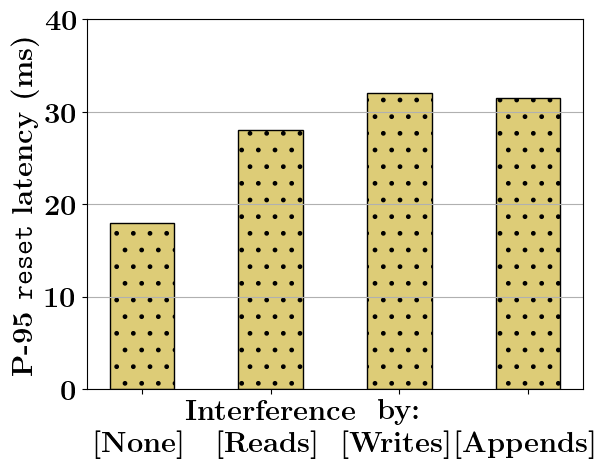

In [22]:
print("Read/reset interference test P95-lat:")
print(f"- normal read lat: {np.percentile(normal_reads,95)}")
print(f"- read during reset lat: {np.percentile(read_int_reads,95)}")
print(f"- reset during read lat: {np.percentile(read_int_resets,95)}")

print("Write/reset interference test P95-lat:")
print(f"- normal write lat: {np.percentile(write_int_fill_writes,95)}")
print(f"- write during reset lat: {np.percentile(write_int_writes,95)}")
print(f"- reset during write lat: {np.percentile(write_int_resets,95)}")

print("Append/reset interference test P95-lat::")
print(f"- normal append lat: {np.percentile(append_int_fill_appends,95)}")
print(f"- append during reset lat: {np.percentile(append_int_appends,95)}")
print(f"- reset during append lat: {np.percentile(append_int_resets,95)}")

print("Pure reset P95 lat:", np.percentile([r for r in reset_100], 95))

fig, ax = plt.subplots()
plt.ylabel(r"\textbf{P-95 \texttt{reset} latency (ms)}")
ax.yaxis.grid() # horizontal lines
plt.ylim(0, 40)

labs = ["\n" + r'\textbf{[None]}', r"\textbf{Interference}" + "\n" + r"\textbf{[Reads]}", 
        r"\textbf{by:}" + "\n" + r"\textbf{[Writes]}", "\n" + r"\textbf{[Appends]}"]
vals = [np.percentile([r / 1000_000 for r in reset_100],95),
        np.percentile([r / 1000_000 for r in read_int_resets] ,95),
        np.percentile([r / 1000_000 for r in write_int_resets] ,95),
        np.percentile([r / 1000_000 for r in append_int_resets],95)]

ax.bar(range(len(labs)), vals, align='center', color=reset_col, 
       hatch=lbaf2_pattern, edgecolor = "black", ecolor="black", width = 0.5)
ax.set_xticks(range(len(labs)), labels=labs)
    
plt.savefig(f"{plot_dir}/f13-reset_inteference.pdf", bbox_inches="tight")